<a href="https://colab.research.google.com/github/rohitfarmer/ColabHDStIM/blob/main/ColabHDStIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDStIM: High Dimensional Stimulation Immune Mapping ('HDStIM')

<img src="https://raw.githubusercontent.com/niaid/HDStIM/master/man/figures/sticker.png" height="200" align="right" style="height:200px">

A method for identifying responses to experimental stimulation in mass or flow cytometry that uses high dimensional analysis of measured parameters and can be performed with an end-to-end unsupervised approach. 

Documentation website: [https://niaid.github.io/HDStIM/](https://niaid.github.io/HDStIM/)  
Source code: [https://github.com/niaid/HDStIM/](https://github.com/niaid/HDStIM/)  
CRAN page: [https://cran.r-project.org/package=HDStIM](https://cran.r-project.org/package=HDStIM)


In [23]:
#@title 1.1 Load Python packages
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
from google.colab import data_table
%config InlineBackend.figure_format = 'retina'


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
#@title 1.2 Install and load R packages
# %%capture --no-stderr
%%R
if(require(HDStIM)){
    print("HDStIM is already installed, loading now.")
    suppressMessages(library(HDStIM))    
}else {
    print("HDStIM is not installed, installing now.")
    suppressWarnings(install.packages("HDStIM"))    
    suppressMessages(library(HDStIM))
}
print("Loading other R packages.")
suppressMessages(library(tidyverse))

## 2 Example data
HDStIM package comes with an example dataset that is used for unit testing during CRAN submission etc. It can also be used as an example on how to format the main single cell marker expression data frame and other parameters passed to the main HDStIM function.

In [21]:
#@title 2.1 An example input data frame/tibble for HDStIM
data_table.enable_dataframe_formatter()
%R head(chi11$expr_data)


,cluster_id,sample_id,condition,patient_id,stim_type,merging1,CD45,CD7,CD19,pPLCg2,...,CD16,CD38,CD8,CD45RA,CD3,pERK1_2,HLA_DR,pS6,CD127,ncount
1,79.0,CHI-011_1_2_A,CHI,CHI-011,A,CD11c CD14 CD38,3.110460,2.601485,0.051145,0.715850,...,0.095006,2.317396,0.297018,0.193045,1.786278,0.042361,2.767460,0.000000,0.328854,1659
2,70.0,CHI-011_1_1_A,CHI,CHI-011,A,CD11c CD14 CD38,3.756624,1.960488,0.000000,1.514682,...,0.000000,0.988323,0.151289,1.141180,1.799318,0.033237,3.873730,0.000000,0.269252,1659
3,69.0,CHI-011_3_10_A,CHI,CHI-011,A,CD11c CD14 CD38,2.911722,1.310564,0.000000,0.000000,...,0.000000,1.730550,0.346478,0.000000,1.597540,0.000000,1.917608,0.000000,0.000000,1659
4,69.0,CHI-011_3_10_A,CHI,CHI-011,A,CD11c CD14 CD38,2.919472,1.376643,0.000000,0.000000,...,0.000000,2.505630,0.000000,0.000000,0.023070,0.000000,0.511052,0.506312,0.000000,1659
5,79.0,CHI-011_4_12_A,CHI,CHI-011,A,CD11c CD14 CD38,2.862431,1.731462,0.000000,0.669274,...,0.939885,0.494881,0.000000,0.096748,0.443139,0.000000,3.327303,0.000000,0.605908,1659
6,70.0,CHI-011_2_6_A,CHI,CHI-011,A,CD11c CD14 CD38,3.554719,2.645969,0.934135,2.007488,...,0.000000,0.756875,0.000000,0.063922,1.420914,0.545795,4.552686,0.279161,0.286081,1659


In [6]:
#@title 2.2 Examples for other input parameters for HDStIM
%%R
cat("State markers\n")
cat(chi11$state_markers)
cat("\n\nCluster col\n")
cat(chi11$cluster_col)
cat("\n\nStim labels\n")
cat(chi11$stim_label)
cat("\n\nUnstim labels\n")
cat(chi11$unstim_label)

State markers
pPLCg2 pSTAT5 AKT pSTAT1 pP38 pSTAT3 IkBa pCREB pERK1_2 pS6

Cluster col
merging1

Stim labels
A T L G

Unstim labels
U

## 3 Upoad data for the analysis
There are multiple ways through which you can upload data into the Colab environment to use with HDStIM. Below are three in order of their speed. 

1. **Preferred:** uploading data to your/temporary Google Drive and downloading the data using `! gdown` command.
2. **As fast as the first one:** mounting your Google Drive in this notebook and giving the path to the data in your Google Drive. This option is very fast, however, *it would require you to give the notebook read and write permision to your Google Drive.*
3. **Very very slow:** Using files tab on the left hand side and using the built in colab file upload option. However, it is very slow and might only be *useful for small datasets (< 1GB)*.
 




In [19]:
#@title 3.1 Upload data from a Google Drive using "gdown"
download_url = "" #@param {type:"string"}

if download_url == "":
  print("Please enter a url")
else:
  ! gdown download_url

Please enter a url


In [9]:
#@title 3.2 Mount google drive to load and save data (optional)
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#@title 3.3 Read the uploaded data for HDStIM

%%R

file_type = "RDS" #@param ["TSV", "RDS"]
path_to_file = "/content/input_data.rds" #@param {type:"string"}
if(file_type == "TSV"){
  data_in <- read_tsv(file.path(path_to_file), 
                      show_col_types = FALSE)
} else if(file_type == "RDS"){
    data_in <- readRDS(file.path(path_to_file))
}

In [ ]:
#@title 3.4 Preview input data (optional)
%R data_in

## 4 HDSTiM

The main HDStIM function requires the following data and parameters.

1. `dat:` A tibble with the single cell data. Cells on rows and markers on columns. Mandatory columns include `condition` (contrast conditions), `stim_type` (labels for stimulants), and a column with cell population names. In addition to marker expression and madatory columns other covariates can also be included. 	
2. `state_markers:` A character vector with the labels of state markers from the stimulation panel.
3. `cellpop_col:` Column in the tibble with the cell population IDs.
4. `stim_lab:` A character vector of stim label(s). This list should be the same as stimuli labels in the `stim_type` column.
5. `unstim_lab:` A character vector of unstim label(s). This list should be the same as mentioned in the `stim_type` column.
6. `umap:` Boolean (TRUE/FALSE) to carry out UMAP on the selected cells.
7. `umap_cells:` An integer; for calculating UMAPs take a minimum of `umap_cells` per cluster or the total number of cells if the cluster size is smaller than umap_cells.

In [151]:
#@title 4.1 Input parameters for the main HDStIM function
%%R
#expr_data <- data_in #@param {type:"raw"}
state_markers <- "pPLCg2, pSTAT5, AKT, pSTAT1, pP38, pSTAT3, IkBa, pCREB, pERK1_2, pS6" #@param {type:"string"}
state_markers <- stringr::str_replace_all(stringr::str_split(state_markers, ",")[[1]], " ", "")
cluster_col <- "merging1" #@param {type:"string"}
stim_label <- "A" #@param {type:"string"}
stim_label <- stringr::str_replace_all(stringr::str_split(stim_label,",")[[1]], " ", "")
unstim_label <- "U" #@param {type:"string"}
unstim_label <- stringr::str_replace_all(stringr::str_split(unstim_label,",")[[1]], " ", "")
umap <- "FALSE" #@param {type:"string"}
umap_cells <- 500 #@param {type:"number"}

In [152]:
#@title 4.2 Run HDStIM
%%R
mapped_data <-  HDStIM(data_in, state_markers, cluster_col, stim_label,
                       unstim_label, seed_val = 123, 
                       umap = umap, umap_cells = umap_cells, 
                       verbose = FALSE)
sig_spc <- dplyr::filter(mapped_data$all_fisher_p_val, p.value < 0.05)
n_sig_spc <- nrow(sig_spc)


In [153]:
#@title 4.3 Responding populations mapped by HDStIM
data_table.enable_dataframe_formatter()
%R dplyr::select(sig_spc, stim_type, cell_population, p.value)

,stim_type,cell_population,p.value
1,A,CD11c CD14 CD38,3.052288e-26
2,A,CD19 CD20 CD45RA HLA-DR CD24,5.555794e-18
3,A,CD3 CD8 CD127 CD45RA,1.709727e-24
4,A,CD3 CD8 CD27 CD127,3.829911e-23


## 5 HDStIM diagnostic plots

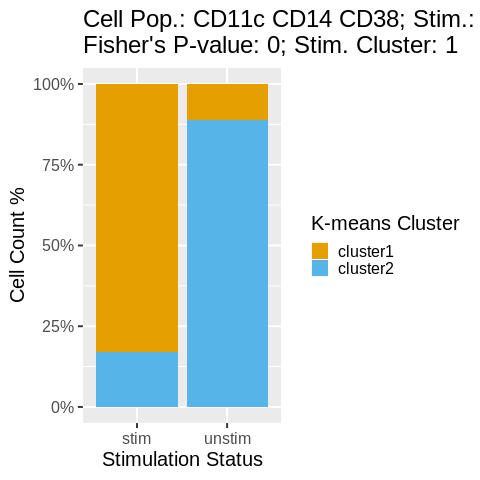

In [154]:
#@title 5.1 Plots to show K-means and Fisher's exact test results { run: "auto" }
%%R
k_plots <- plot_K_Fisher(mapped_data, path = NULL, verbose = FALSE)
if(n_sig_spc ==0){
    print("Nothing to plot here.")
} else if(n_sig_spc > 0){
  plot_index_no = 1 #@param {type:"integer"}
  if(plot_index_no <= n_sig_spc & plot_index_no > 0){
    k_plots[[plot_index_no]]        
  } else {
      print("The selected value is not in the index.")
  }
}



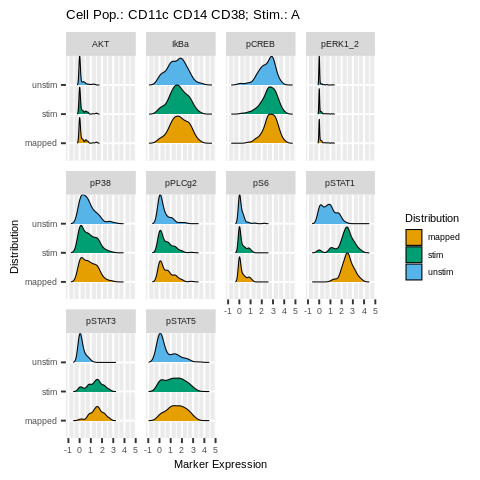

In [155]:
#@title 5.2 Plots to show pre and post HDStIM response marker distribution { run: "auto" }
%%R
e_plots <- plot_exprs(mapped_data, path = NULL,verbose = FALSE)
if(n_sig_spc ==0){
    print("Nothing to plot here.")
} else if(n_sig_spc > 0){
plot_index_no = 1 #@param {type:"integer"}
  if(plot_index_no <= n_sig_spc & plot_index_no > 0){
    e_plots[[plot_index_no]] +
        theme(text = element_text(size = 11))       
  } else {
      print("The selected value is not in the index.")
  }
}

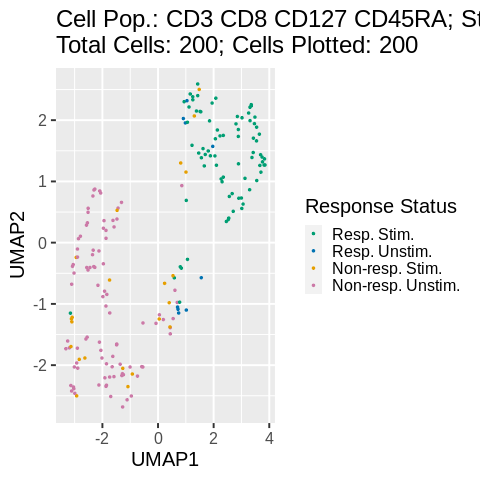

In [156]:
#@title 5.3 Plots to show responsing and non responding cells on a UMAP { run: "auto" }
%%R
if("umap" %in% names(mapped_data)){
  u_plots <- plot_umap(mapped_data, path = NULL, verbose = FALSE)
  if(n_sig_spc ==0){
      print("Nothing to plot here.")
  } else if(n_sig_spc > 0){
    plot_index_no = 3 #@param {type:"integer"}
    if(plot_index_no <= n_sig_spc & plot_index_no > 0){
      u_plots[[plot_index_no]]        
    } else {
        print("The selected value is not in the index.")
    }
  }    
}else{
    print("Umaps were not generated.")
}


## 6 Rank markers per their contribution to the response 

Ranking markers per their contribution to the response through Boruta (random forest) is a time intensive step, especially when the the number of cells in a cell population are large. This function is executed for all the significant SPCs. If many markers are labelled as tentative then increase `max_runs` and rerun the function.**bold text**

In [198]:
#@title 6.1 Run marker ranking
%%R 
n_cells <- "NULL" #@param {type:"string"}
if(n_cells == "NULL"){
    n_cells <- NULL
} else {
    n_cells <- as.integer(n_cells)
}
max_runs <- 100 #@param {type:"integer"}
seed_val <- 123 #@param {type:"integer"}

m_ranks <- marker_ranking_boruta(mapped_data, path = NULL, n_cells = n_cells,
                                 max_runs = max_runs, seed_val = seed_val,
                                 verbose = FALSE)

In [199]:
#@title 6.2 Marker ranking summary
%R m_ranks$attribute_stats

,stim_type,cell_population,state_marker,meanImp,medianImp,minImp,maxImp,normHits,decision
1,A,CD11c CD14 CD38,AKT,0.004937,0.010915,-0.881146,0.775049,0.000000,Rejected
2,A,CD11c CD14 CD38,pP38,0.383926,0.245657,-1.120556,1.610609,0.000000,Rejected
3,A,CD11c CD14 CD38,pERK1_2,2.398167,2.471848,-0.228427,5.026068,0.616162,Tentative
4,A,CD11c CD14 CD38,pS6,2.785485,2.728324,0.605253,5.106503,0.737374,Confirmed
5,A,CD11c CD14 CD38,pPLCg2,2.939929,3.058539,0.001994,5.127609,0.737374,Confirmed
6,A,CD11c CD14 CD38,pCREB,4.644968,4.568588,2.409911,6.688701,0.969697,Confirmed
7,A,CD11c CD14 CD38,IkBa,5.859258,5.788818,3.155923,8.266096,0.979798,Confirmed
8,A,CD11c CD14 CD38,pSTAT5,21.131066,21.142818,18.748566,23.057777,1.000000,Confirmed
9,A,CD11c CD14 CD38,pSTAT3,29.056677,29.182910,25.624419,31.668754,1.000000,Confirmed
10,A,CD11c CD14 CD38,pSTAT1,36.457005,36.377712,32.150055,40.248056,1.000000,Confirmed


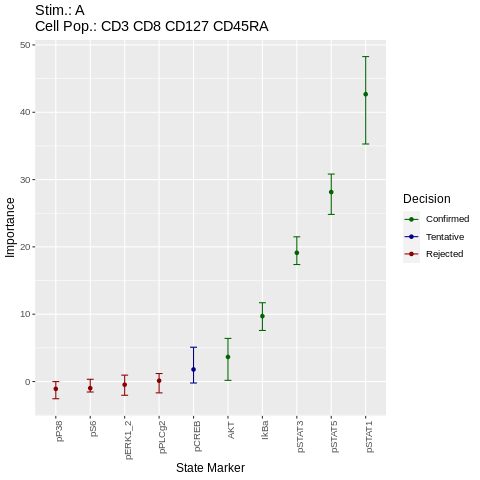

In [200]:
#@title 6.3 Plots to show marker ranking results { run: "auto" }
%%R
if(n_sig_spc ==0){
    print("Nothing to plot here.")
} else if(n_sig_spc > 0){
  plot_index_no = 3 #@param {type:"integer"}
  if(plot_index_no <= n_sig_spc & plot_index_no > 0){
    m_ranks$plots[[plot_index_no]] +
    theme(text = element_text(size = 12))
  } else {
      print("The selected value is not in the index.")
  }
}



## Download analysis results
You can save all the analysis result in your Google drive; if you have mounted it. Else save files locally in the Colab runtime and then download them individually to your local machine **(preferred)**.  

In [136]:
#@title Output folder
%%R
path_to_output_folder = "/content/hdstim-out" #@param {type:"string"}
if(file.exists(path_to_output_folder)){
    cat("WARNING: Output folder exists. Results will be over written.")
} else{
    cat("WARNING: Output folder does not exists. Please create one.")
}


In [ ]:
#@title Save HDStIM output and diagnostic plots in the output folder
%%R
saveRDS(mapped_data, file.path(path_to_output_folder, 
                               "hdstim-main-out.rds"))
write_tsv(mapped_data$all_fisher_p_val, file.path(path_to_output_folder, 
                                                  "all-fisher-data.tsv"))

# HDStIM diagnostic plots
## K Fisher plots
theme_set(theme_grey())
k_plots_path <- file.path(path_to_output_folder, "k-fisher-plots")
dir.create(k_plots_path, recursive = TRUE, showWarnings = FALSE )
k_plots <- plot_K_Fisher(mapped_data, path = k_plots_path, verbose = FALSE)
### Create tar.gz and delete individual plot files
tar(file.path(path_to_output_folder,"k-fisher-plots.tar.gz")
, files=k_plots_path, compression="gzip")
### Delete original uncompressed files
delete_uncompressed_files_k = "TRUE" #@param {type:"string"}
if(delete_uncompressed_files_k == "TRUE") {
    unlink(k_plots_path, recursive = TRUE)
}

## Pre and post HDStIM maker expression plots
theme_set(theme_grey())
e_plots_path <- file.path(path_to_output_folder, "pre-post-hdstim-expr-plots")
dir.create(e_plots_path, recursive = TRUE, showWarnings = FALSE )
e_plots <- plot_exprs(mapped_data, path = e_plots_path,verbose = FALSE)
### Create tar.gz and delete individual plot files
tar(file.path(path_to_output_folder,"pre-post-hdstim-expr-plots.tar.gz")
, files=e_plots_path, compression="gzip")
### Delete original uncompressed files
delete_uncompressed_files_e = "TRUE" #@param {type:"string"}
if(delete_uncompressed_files_e == "TRUE") {
    unlink(e_plots_path, recursive = TRUE)
}

## UMAP if UMAPs are generated during HDStIM
if("umap" %in% names(mapped_data)){
    theme_set(theme_grey())
    u_plots_path <- file.path(path_to_output_folder, "umap-plots")
    dir.create(u_plots_path, recursive = TRUE, showWarnings = FALSE )
    u_plots <- plot_umap(mapped_data, path = u_plots_path, verbose = FALSE)
    ### Create tar.gz and delete individual plot files
    tar(file.path(path_to_output_folder,"umap-plots.tar.gz")
    , files=u_plots_path, compression="gzip")
    ### Delete original uncompressed files
    delete_uncompressed_files_u = "TRUE" #@param {type:"string"}
    if(delete_uncompressed_files_u == "TRUE") {
      unlink(u_plots_path, recursive = TRUE)
  }
}


In [196]:
#@title Save marker ranking output and plots (if marker ranking was executed)
%%R
saveRDS(m_ranks, file.path(path_to_output_folder, 
                           "marker-ranking-main-out.rds"))
write_tsv(m_ranks$attribute_stats, file.path(path_to_output_folder, 
                                             "marker-ranking-attributes-table.tsv"))

# Marker ranking plots
c_s_comb <- m_ranks$attribute_stats %>% dplyr::select(stim_type, cell_population) %>%
dplyr::group_by(, stim_type, cell_population) %>%
ungroup() %>%
unique()

theme_set(theme_grey())
mr_plots_path <- file.path(path_to_output_folder, "marker-ranking-plots")
dir.create(mr_plots_path, recursive = TRUE, showWarnings = FALSE )
for(i in 1:nrow(c_s_comb)){
    att_plot <- m_ranks$plots[[i]]
    stim <- c_s_comb$stim_type[i]
    clust <- c_s_comb$cell_population[i]
    att_file <- paste0("imp_", stim, "_", clust, ".png")
    ggsave(att_file, plot = att_plot, path = mr_plots_path,
           device = "png", dpi = 300, width = 7, height = 6, units = "in")
}

# Create tar.gz and delete individual plot files
tar(file.path(path_to_output_folder,"marker-ranking-plots.tar.gz")
, files=mr_plots_path, compression="gzip")

# Delete original uncompressed files
delete_uncompressed_files = "FALSE" #@param {type:"string"}
if(delete_uncompressed_files == "TRUE") {
    unlink(mr_plots_path, recursive = TRUE)
}


# Done
